# HDBSCAN Clustering for RBD sequences 
# (NON from_esm_mlm)
---
### Parquet Making
We will be making a parquet for the entire file. Then we can sample from it randomly.

In [ ]:
import os
import sys
import torch
import time
import datetime
import pandas as pd
from torch.utils.data import Dataset, DataLoader

from transformers import EsmTokenizer, EsmModel 

import lightning as L

# Parquet Making
class RBDDataset(Dataset):
    """ BetaCorona virus sequence dataset, embedded with ESM model. """

    def __init__(self, csv_file:str):
        try:
            self.df = pd.read_csv(csv_file, sep=',', header=0, na_filter=False)
        except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
            print(f"Error reading in .csv file: {csv_file}\n{e}", file=sys.stderr)
            sys.exit(1)

        self.max_len = self.df['sequence'].apply(len).max()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        columns = (
            self.df.iloc[idx]["seq_id"],
            self.df.iloc[idx]["variant"],
            self.df.iloc[idx]["Pango lineage"],
            self.df.iloc[idx]["Location"],
            self.df.iloc[idx]["Collection date"],
            self.df.iloc[idx]["AA Substitutions"],
            self.df.iloc[idx]["sequence"],
        )
        return columns

class RBDDataModule(L.LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int, num_workers: int, seed: int):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed

        # Set seeds globally for reproducibility
        L.seed_everything(self.seed, workers=True)

    def setup(self, stage):
        # Called on every GPU
        if stage == 'test':
            self.test_dataset = RBDDataset(os.path.join(self.data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.csv"))

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False,
            drop_last=False, 
            num_workers=self.num_workers,
            generator=torch.Generator().manual_seed(self.seed),
            pin_memory=True
        )

class LightningProteinEsmEmbedder(L.LightningModule):
    def __init__(self, max_len: int, csv_file:str, esm_version="facebook/esm2_t6_8M_UR50D", from_esm_mlm=None):
        super().__init__()
        self.tokenizer = EsmTokenizer.from_pretrained(esm_version, cache_dir="../../.cache")
        self.model = EsmModel.from_pretrained(esm_version, cache_dir="../../.cache")
        self.from_esm_mlm = from_esm_mlm
        self.max_len = max_len
        self.csv_file = csv_file
        self.batch_dataframes = []

        # Load fine-tuned weights from Lightning ESM_MLM ckpt
        if from_esm_mlm is not None:
            if trainer.global_rank == 0: print(f"Loading ESM_MLM checkpoint from {from_esm_mlm}...")

            ckpt = torch.load(from_esm_mlm, map_location="cpu")
            state_dict = ckpt["state_dict"]

            # Remove "model." prefix and filter out EsmMaskedLM specific keys
            new_state_dict = {}
            for key, value in state_dict.items():
                # Remove "model." prefix
                new_key = key.replace("model.esm.", "model.")

                # Filter out EsmMaskedLM keys (e.g., lm_head.*)
                if "lm_head" not in new_key:
                    new_state_dict[new_key] = value

            # Load weights non-strictly
            missing, unexpected = self.load_state_dict(new_state_dict, strict=False)

            # Define keys to ignore in missing list, these won't exist in the ESM_MLM
            ignored_missing = {
                'model.pooler.dense.weight', 'model.pooler.dense.bias', 'model.embeddings.position_embeddings.weight'
            }

            # Filter out ignored missing keys
            filtered_missing = [k for k in missing if k not in ignored_missing]

            # Raise error if any unexpected keys are missing
            if filtered_missing: raise RuntimeError(f"Missing unexpected keys from ESM_MLM checkpoint: {filtered_missing}")

            if trainer.global_rank == 0:
                print("ESM_MLM checkpoint loaded successfully.")

                if unexpected: print("Unexpected keys:", unexpected)

    def forward(self, input_ids, attention_mask):
        esm_last_hidden_state = self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state # shape: [batch_size, sequence_length, embedding_dim]
        esm_cls_embedding = esm_last_hidden_state[:, 0, :]  # CLS token embedding (sequence-level representations), [batch_size, embedding_dim]
        return esm_cls_embedding

    def test_step(self, batch, batch_idx):
        seq_ids, variants, pango_lineages, locations, collection_dates, aa_subs, seqs = batch 

        tokenized_seqs = self.tokenizer(seqs, return_tensors="pt", padding=True, truncation=True, max_length=self.max_len)
        tokenized_seqs = {k: v.to(self.device) for k, v in tokenized_seqs.items()}

        cls_embeddings = self(input_ids=tokenized_seqs["input_ids"], attention_mask=tokenized_seqs["attention_mask"])

        # Create a DataFrame for the batch
        batch_df = pd.DataFrame({
            "seq_id": seq_ids,
            "variant": variants,
            "Pango lineage": pango_lineages,
            "Location": locations,
            "Collection date": collection_dates,
            "AA Substitutions": aa_subs,
            "embedding": [embedding.detach().cpu().numpy() for embedding in cls_embeddings]  # Convert tensor to numpy array for each embedding
        })

        self.batch_dataframes.append(batch_df)

    def on_test_epoch_end(self):
        # Concatenate all batch DataFrames into one
        result_df = pd.concat(self.batch_dataframes, ignore_index=True)
    
        # Save data to a Parquet file
        save_as = self.csv_file.replace(".csv", f"{'.from-esm-mlm.' if self.from_esm_mlm is not None else '.'}CLS-embedded.parquet")
        result_df.to_parquet(save_as, index=False)
        print(f"Data saved to {save_as}.")

seed = 0
L.seed_everything(seed)  # Set seed for reproducibility
data_dir = "../../../data/rbd"

# Trainer setup 
trainer= L.Trainer(
    limit_test_batches=1.0, # 1.0 is 100% of batches 
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    num_nodes=1,
    devices=1,
    logger=False,
    enable_progress_bar=True
)

# Initialize DataModule and model
dm = RBDDataModule(
    data_dir = data_dir,
    batch_size = 64,
    num_workers = 4, 
    seed = seed
)
dm.setup("test")

model = LightningProteinEsmEmbedder(
    max_len = dm.test_dataset.max_len + 2, # Account for CLS, EOS tokens
    csv_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.csv"),
    esm_version = "facebook/esm2_t6_8M_UR50D",
    from_esm_mlm = "../best_model-epoch=73.val_loss=0.0022.val_accuracy=99.6612.ckpt"
)

start_time = time.perf_counter()
trainer.test(model, dm)  # Test model
duration = datetime.timedelta(seconds=time.perf_counter()-start_time)
print(f"[Timing] Test.fit(...) took: {duration} (hh:mm:ss).")

seed = 0
L.seed_everything(seed)  # Set seed for reproducibility
data_dir = "../../../data/rbd"

# Trainer setup 
trainer= L.Trainer(
    limit_test_batches=1.0, # 1.0 is 100% of batches 
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    num_nodes=1,
    devices=1,
    logger=False,
    enable_progress_bar=True
)

# Initialize DataModule and model
dm = RBDDataModule(
    data_dir = data_dir,
    batch_size = 64,
    num_workers = 4, 
    seed = seed
)
dm.setup("test")

model = LightningProteinEsmEmbedder(
    max_len = dm.test_dataset.max_len + 2, # Account for CLS, EOS tokens
    csv_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.csv"),
    esm_version = "facebook/esm2_t6_8M_UR50D"
)

start_time = time.perf_counter()
trainer.test(model, dm)  # Test model
duration = datetime.timedelta(seconds=time.perf_counter()-start_time)
print(f"[Timing] Test.fit(...) took: {duration} (hh:mm:ss).")

---
### Clustering - tSNE, then HDBSCAN
Sampling from the embeddings. 

In [ ]:
import os
import pandas as pd

data_dir = "../../../data/rbd"

parquet_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')

# Random sampling
min_sample_size = embedded_ado_df['variant'].value_counts().min()
sample_sizes = {"Alpha": min_sample_size,
                "Delta": min_sample_size,
                "Omicron": min_sample_size}

rnd_seed = 0
sampled_dfs = [embedded_ado_df[embedded_ado_df['variant'] == variant].sample(n=sample_sizes[variant], random_state=rnd_seed)
                           for variant in sample_sizes.keys()]
    
sampled_ado_df = pd.concat(sampled_dfs)
print(sampled_ado_df['variant'].value_counts())

save_as = f"RBD.ADO.CLS-embedded.sampled_seed{rnd_seed}.parquet"
sampled_ado_df.to_parquet(save_as, index=False)

Apply tSNE to the embeddings, then save the tSNE embeddings.

Perplexity 30: Time taken = 46.94 seconds.
Perplexity 50: Time taken = 51.86 seconds.
Perplexity 100: Time taken = 72.29 seconds.
Perplexity 250: Time taken = 126.96 seconds.
Perplexity 500: Time taken = 213.61 seconds.
Perplexity 750: Time taken = 248.43 seconds.
Perplexity 800: Time taken = 256.50 seconds.
Perplexity 900: Time taken = 260.79 seconds.
Perplexity 1000: Time taken = 266.97 seconds.


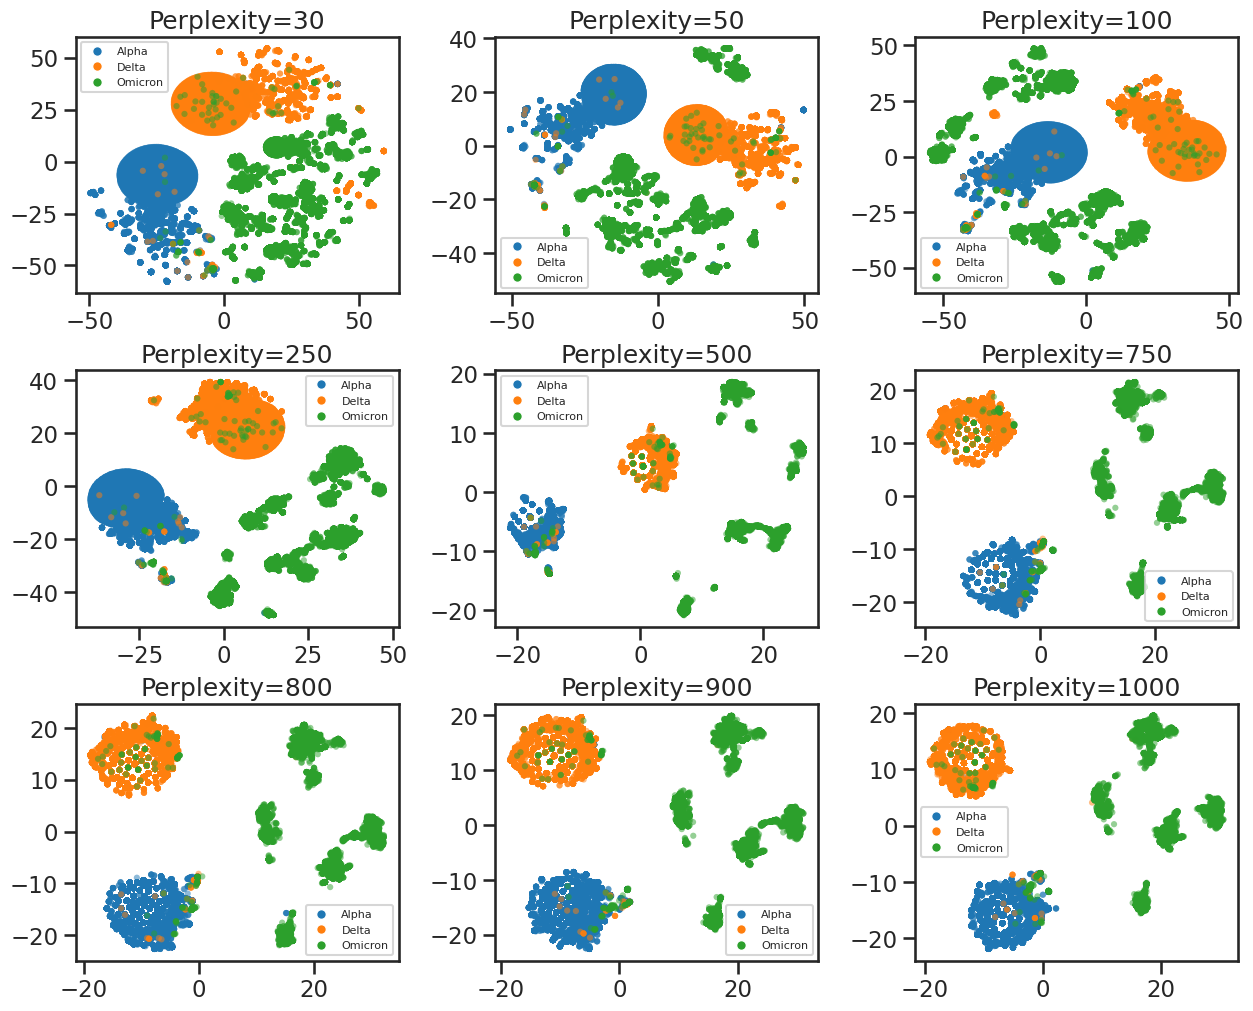

Perplexity 600: Time taken = 234.58 seconds.
Perplexity 650: Time taken = 239.36 seconds.
Perplexity 700: Time taken = 250.70 seconds.
Perplexity 850: Time taken = 272.65 seconds.


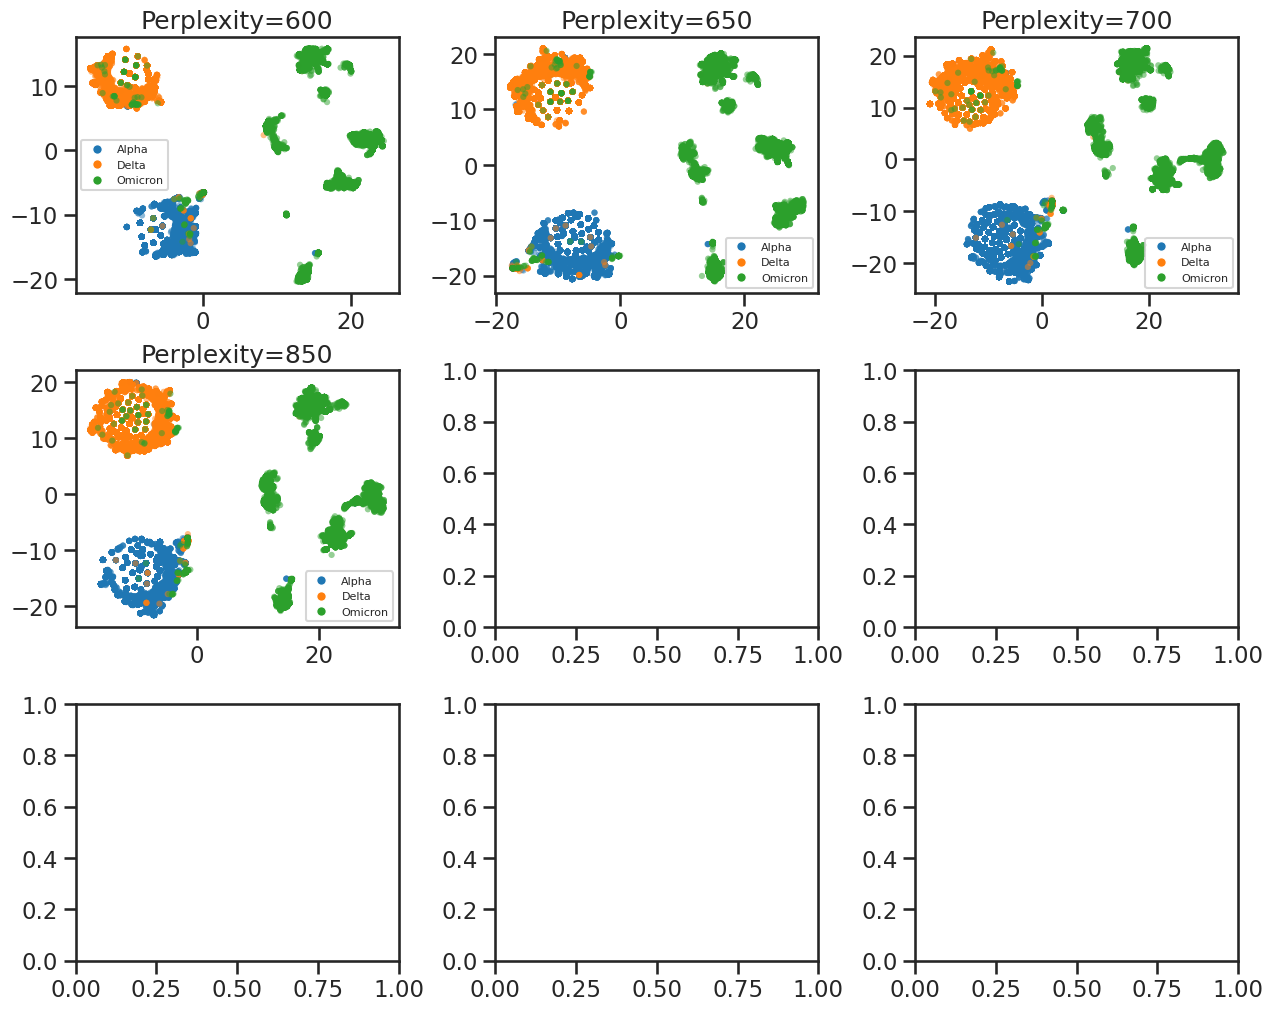

In [3]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openTSNE import TSNE

def plot_perplexities(parquet_file, perp_list):
    n_rows = 3
    n_cols = 3
    sns.set_style('ticks')
    sns.set_context("talk")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
    embedding_matrix = np.vstack(embedded_df["embedding"])

    for ax, perp in zip(axes.flat, perp_list):

        start_time = time.perf_counter()

        tsne_reducer = TSNE(n_components=2, perplexity=perp, learning_rate='auto', random_state=42, n_jobs=32)
        embedding_matrix_reduced = tsne_reducer.fit(embedding_matrix)
        
        end_time = time.perf_counter()
        elapsed = end_time-start_time
        print(f"Perplexity {perp}: Time taken = {elapsed:.2f} seconds.")

        plot_df = pd.DataFrame({
            't-SNE component 1': embedding_matrix_reduced[:, 0],
            't-SNE component 2': embedding_matrix_reduced[:, 1],
            'Seq ID': embedded_df['seq_id'],
            'Variant': embedded_df['variant'],
            'Pango lineage': embedded_df['Pango lineage'],
            'Collection date': embedded_df['Collection date']
        })
        save_as = parquet_file.replace(".parquet", f".tSNE-perplexity{perp}.parquet")
        plot_df.to_parquet(save_as, engine='fastparquet')

        unique_variants = np.unique(plot_df['Variant'])
        variant_color_palette = sns.color_palette("tab10", n_colors=len(unique_variants)) 
        variant_color_dict = {label: color for label, color in zip(unique_variants, variant_color_palette)}
        variant_colors = [variant_color_dict[v] for v in plot_df['Variant']]

        ax.scatter(plot_df['t-SNE component 1'], plot_df['t-SNE component 2'],
                c=variant_colors, s=20, alpha=0.5, edgecolor='none', linewidth=0)
        ax.set_title(f'Perplexity={perp}')
        
        # Create per-plot legend
        handles = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=variant_color_dict[v], markersize=7)
            for v in unique_variants
        ]
        labels = unique_variants
        ax.legend(handles, labels, loc='best', fontsize=8, title_fontsize=9)

    plt.show()

seed = 0
plot_perplexities(
    parquet_file = f"RBD.ADO.CLS-embedded.sampled_seed{seed}.parquet",
    perp_list = [30, 50, 100, 250, 500, 750, 800, 900, 1000]
)
plot_perplexities(
    parquet_file = f"RBD.ADO.CLS-embedded.sampled_seed{seed}.parquet",
    perp_list = [600, 650, 700, 850]
)

Find highest or a sufficiently highest Silhouette Coefficient, Adjusted Rand Index.

min_sample 100, min_cluster_size 1000: Adjusted Rand Index: 0.18, Silhouette Coefficient: 0.28
min_sample 100, min_cluster_size 5000: Adjusted Rand Index: 0.72, Silhouette Coefficient: 0.68
min_sample 100, min_cluster_size 10000: Adjusted Rand Index: 0.80, Silhouette Coefficient: 0.66
min_sample 100, min_cluster_size 15000: Adjusted Rand Index: 0.80, Silhouette Coefficient: 0.66
min_sample 100, min_cluster_size 20000: Adjusted Rand Index: 0.48, Silhouette Coefficient: 0.43
min_sample 100, min_cluster_size 22000: Adjusted Rand Index: 0.48, Silhouette Coefficient: 0.43
min_sample 500, min_cluster_size 1000: Adjusted Rand Index: 0.14, Silhouette Coefficient: 0.27
min_sample 500, min_cluster_size 5000: Adjusted Rand Index: 0.84, Silhouette Coefficient: 0.74
min_sample 500, min_cluster_size 10000: Adjusted Rand Index: 0.84, Silhouette Coefficient: 0.74
min_sample 500, min_cluster_size 15000: Adjusted Rand Index: 0.97, Silhouette Coefficient: 0.73
min_sample 500, min_cluster_size 20000: Adju

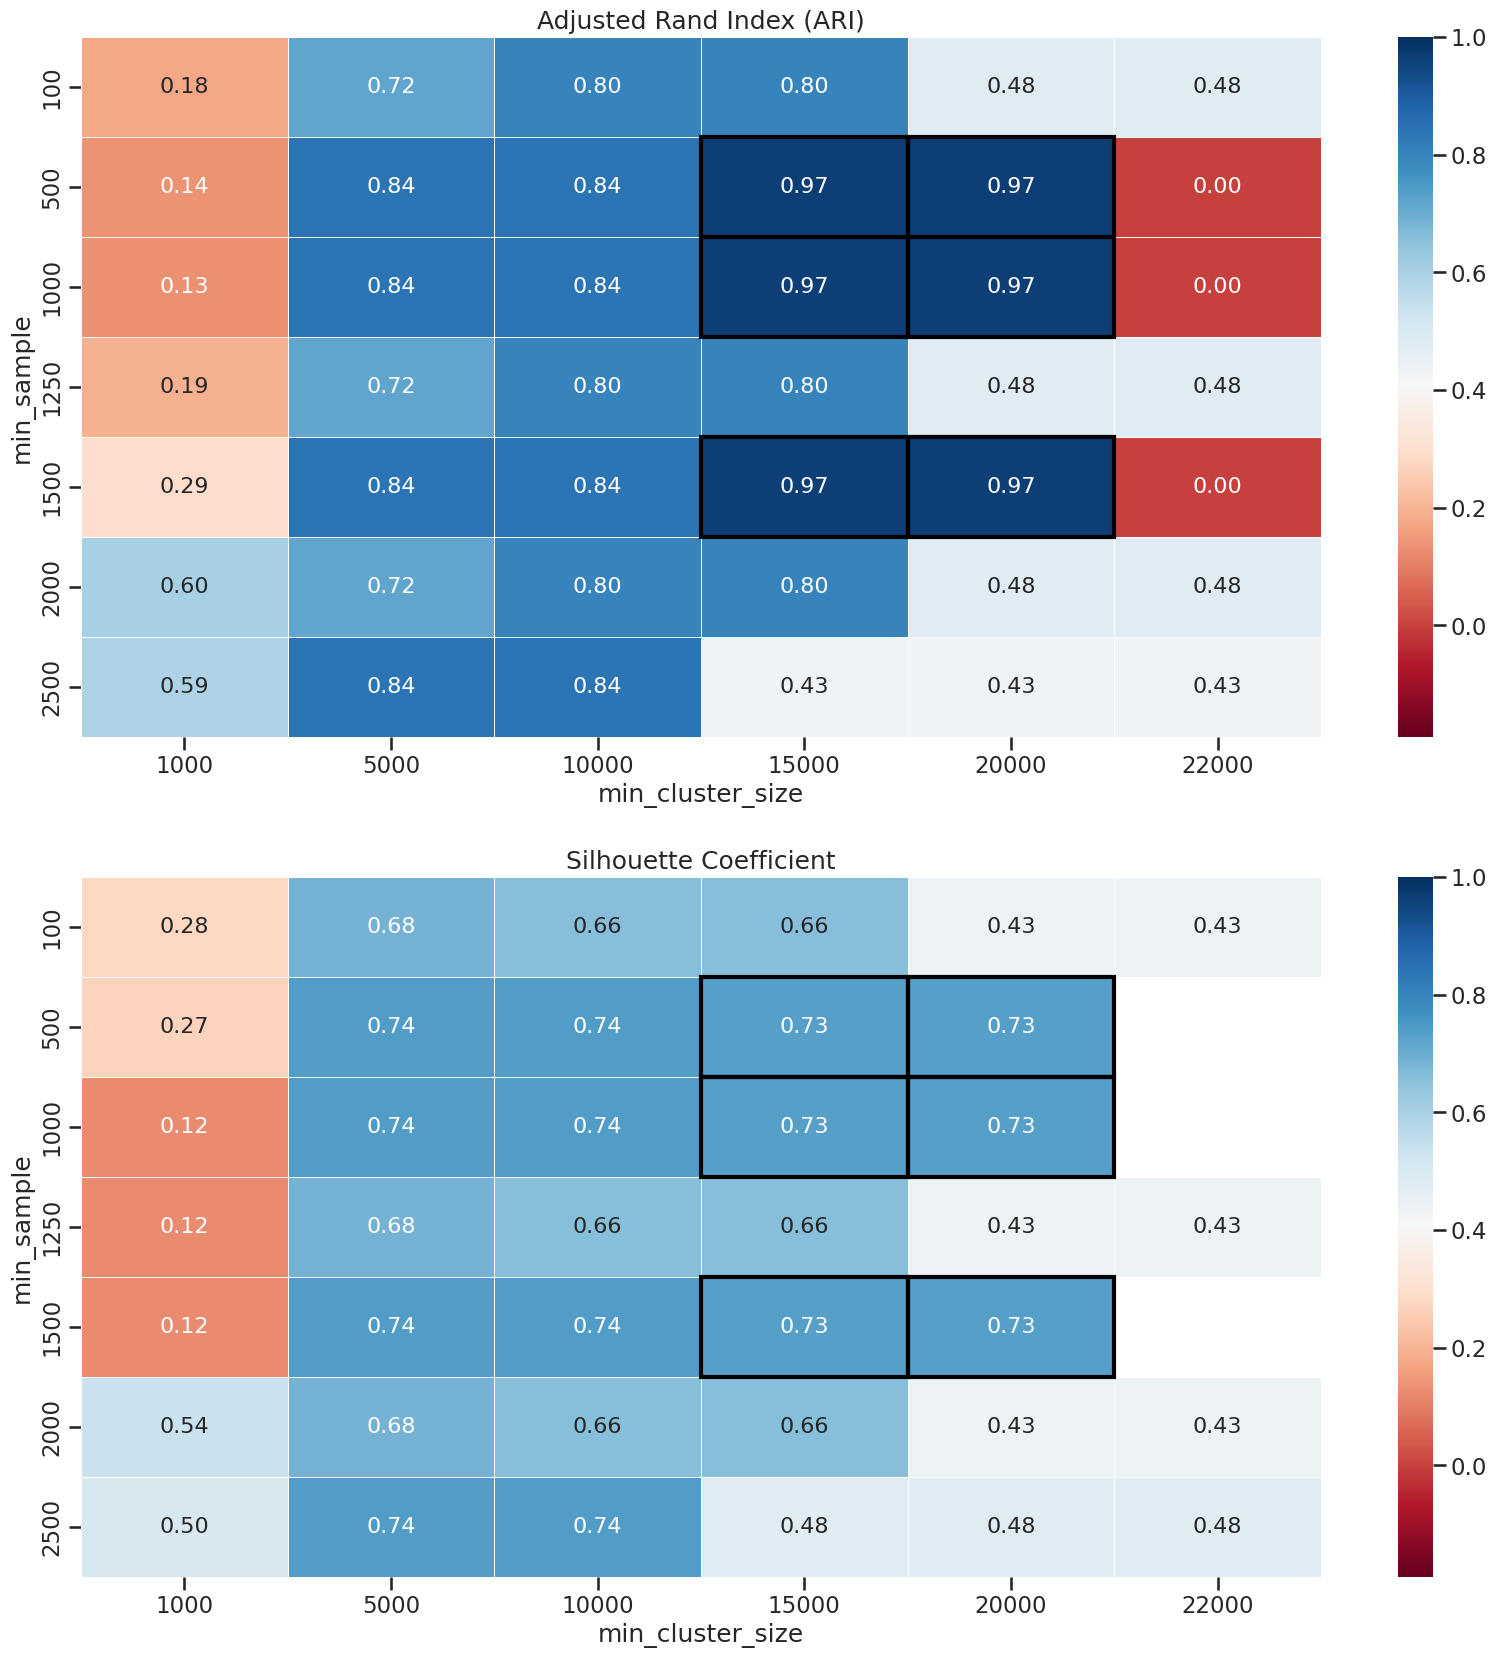

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import time
import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def ari_sc_heatmap(parquet_file, perp):
    embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
    embedding_matrix = embedded_df[['t-SNE component 1', 't-SNE component 2']].values

    start_time = time.perf_counter()

    results = []
    for ms in [100, 500, 1000, 1250, 1500, 2000, 2500]:
        for mcs in [1000, 5000, 10000, 15000, 20000, 22000]:
            # Cluster
            clusterer = hdbscan.HDBSCAN(
                min_samples=ms,
                min_cluster_size=mcs,
                core_dist_n_jobs=-1
            ).fit(embedding_matrix)

            labels = clusterer.labels_

            # Evaluate clustering
            ari = adjusted_rand_score(embedded_df["Variant"], labels)

            # Check number of clusters (excluding noise)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1:
                silhouette_avg = silhouette_score(embedding_matrix, labels)
            else:
                silhouette_avg = np.nan  # or 0, depending on how you want to treat it

            # Store results
            results.append({
                "min_sample": ms,
                "min_cluster_size": mcs,
                "ari": ari,
                "silhouette": silhouette_avg
            })

            print(f"min_sample {ms}, min_cluster_size {mcs}: Adjusted Rand Index: {ari:.2f}, Silhouette Coefficient: {silhouette_avg:.2f}")

    end_time = time.perf_counter()
    elapsed = end_time-start_time
    print(f"Perplexity {perp} HDBSCAN: Time taken = {elapsed:.2f} seconds.")

    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Pivot matrices
    ari_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='ari')
    silhouette_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='silhouette')

    # Plot heatmaps
    sns.set_style('ticks')
    sns.set_context("talk")
    fig, axs = plt.subplots(2, 1, figsize=(20, 20))

    sns.heatmap(ari_matrix, annot=True, annot_kws={"size": 16}, fmt=".2f", linewidth=.5, cmap="RdBu", ax=axs[0], vmin=-0.19, vmax=1)
    axs[0].set_title("Adjusted Rand Index (ARI)")
    axs[0].set_xlabel("min_cluster_size")
    axs[0].set_ylabel("min_sample")

    max_ari = ari_matrix.max().max()  # Get the max ARI value

    for i in range(ari_matrix.shape[0]):  # min_sample (rows)
        for j in range(ari_matrix.shape[1]):  # min_cluster_size (cols)
            if np.isclose(ari_matrix.iloc[i, j], max_ari):  # Safe float comparison
                axs[0].add_patch(
                    plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=3)
                )

    sns.heatmap(silhouette_matrix, annot=True, annot_kws={"size": 16}, fmt=".2f", linewidth=.5, cmap="RdBu", ax=axs[1], vmin=-0.19, vmax=1)
    axs[1].set_title("Silhouette Coefficient")
    axs[1].set_xlabel("min_cluster_size")
    axs[1].set_ylabel("min_sample")

    for i in range(ari_matrix.shape[0]):  # min_sample (rows)
        for j in range(ari_matrix.shape[1]):  # min_cluster_size (cols)
            if np.isclose(ari_matrix.iloc[i, j], max_ari):  # Safe float comparison
                axs[1].add_patch(
                    plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=3)
                )
    save_as = parquet_file.replace(".parquet", ".HDBSCAN_heatmap")
    plt.savefig(f"{save_as}.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.show()

perp = 1000
seed = 0
parquet_file = f"RBD.ADO.CLS-embedded.sampled_seed{seed}.tSNE-perplexity{perp}.parquet"
ari_sc_heatmap(parquet_file, perp)

Plotting the tSNE embeddings after applying HDBSCAN.

min_sample 500, min_cluster_size 15000: Adjusted Rand Index: 0.97, Silhouette Coefficient: 0.73


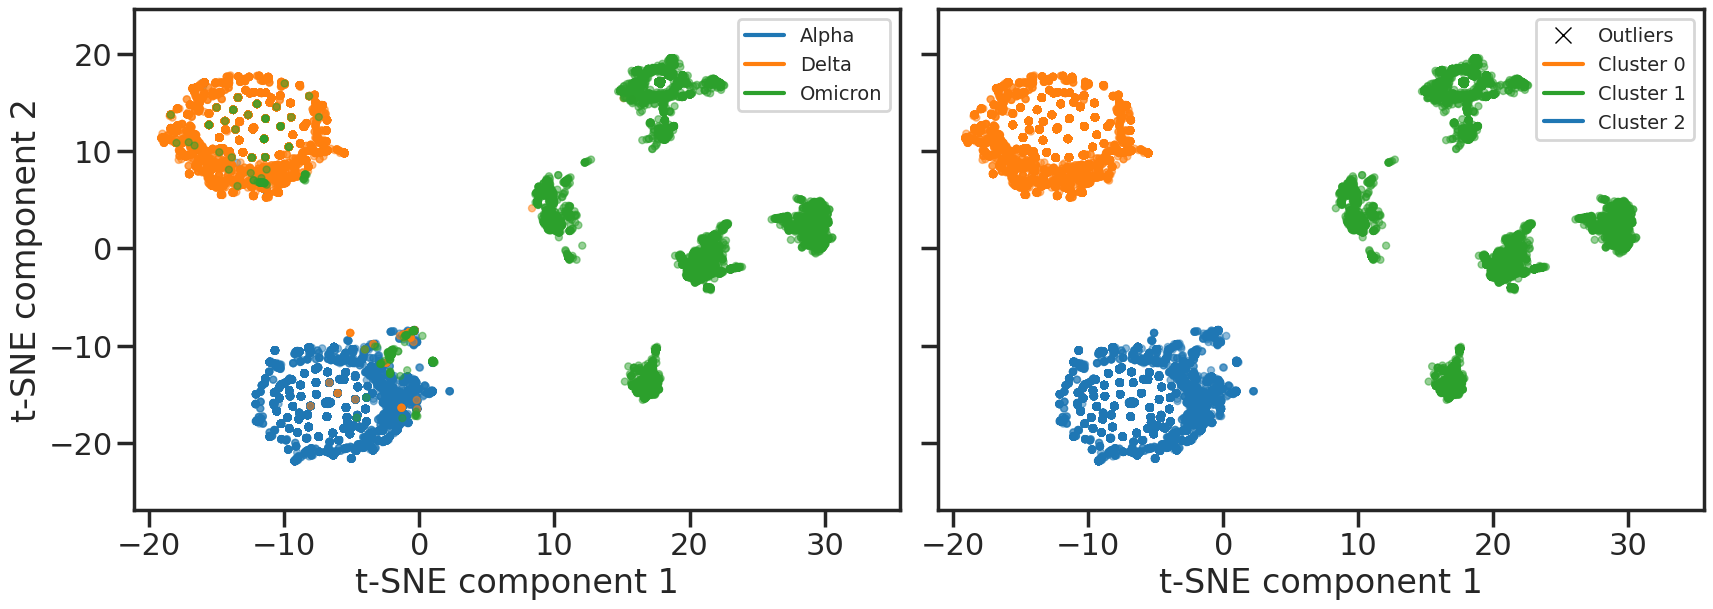

Predicted Clusters,0,1,2
Ground Truth,,,
Alpha,0.43,0.00,99.57
Delta,98.69,0.03,1.28
Omicron,0.34,98.26,1.40


In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score

def get_hdbscan_values(parquet_file, min_samples, min_cluster_size):
    embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
    embedding_matrix = embedded_df[['t-SNE component 1', 't-SNE component 2']].values

    # Cluster
    hdb_labels = hdbscan.HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size,
        core_dist_n_jobs=-1  # Enable parallel processing
    ).fit(embedding_matrix).labels_

    # Evaluate clustering
    silhouette_avg = silhouette_score(embedding_matrix, hdb_labels)
    ari = adjusted_rand_score(embedded_df["Variant"], hdb_labels)
    print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Adjusted Rand Index: {ari:.2f}, Silhouette Coefficient: {silhouette_avg:.2f}")

    # Create the truth table
    truth_table_percent = pd.crosstab(embedded_df["Variant"], hdb_labels, 
                                    rownames=['Ground Truth'], 
                                    colnames=['Predicted Clusters'],
                                    normalize='index')  # Normalize along the index (rows)
    truth_table_percent = (truth_table_percent * 100).round(2)

    # Save
    plot_df = pd.DataFrame({
        't-SNE component 1': embedded_df['t-SNE component 1'],
        't-SNE component 2': embedded_df['t-SNE component 2'],
        'Cluster': hdb_labels,
        'Seq ID': embedded_df['Seq ID'],
        'Variant': embedded_df['Variant'],
        'Pango lineage': embedded_df['Pango lineage'],
        'Collection date': embedded_df['Collection date']
    })    
    save_as = parquet_file.replace(".parquet", f".HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-ari{ari:.2f}_sc{silhouette_avg:.2f}")
    plot_df.to_parquet(f"{save_as}.parquet", engine='fastparquet')
    
    return plot_df, truth_table_percent, save_as

def plot_groundtruth_prediction_1x2(plot_df, save_as, x_min_width_buffer, x_max_width_buffer, y_min_width_buffer, y_max_width_buffer, color_map, cluster_color_palette_order):
    marker_size = 25
    
    # Define a variant color palette
    unique_variants = np.unique(plot_df['Variant'])
    variant_color_palette = sns.color_palette(color_map, n_colors=len(unique_variants)) 
    variant_color_dict = {label: color for label, color in zip(unique_variants, variant_color_palette)}

    # Define a cluster color palette
    unique_clusters = np.unique(plot_df['Cluster'])
    cluster_color_palette = sns.color_palette(color_map, n_colors=10) 
    cluster_color_palette = [cluster_color_palette[i] for i in cluster_color_palette_order]
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_color_palette)}
    cluster_color_dict[-1] = 'black'  # Set outliers to x

    sns.set_style('ticks')
    sns.set_context("poster")
    fig, axs = plt.subplots(1, 2, figsize=(20.25, 6.5), sharey=True)
    fig.subplots_adjust(wspace=0.05)  # Reduce the horizontal space between subplots

    #####################################################

    # Scatterplot
    sns.scatterplot(
        data=plot_df,
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Variant', palette=variant_color_dict, 
        s=marker_size, alpha=0.5, edgecolor=None, linewidth=1,
        ax=axs[0]
    )

    # axs[0].set_title(f"Ground Truth ({len(unique_variants)} variants)", ha='center', fontweight='bold')
    axs[0].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+x_max_width_buffer))
    axs[0].set_ylim(plot_df['t-SNE component 2'].min()-y_min_width_buffer, plot_df['t-SNE component 2'].max()+y_max_width_buffer),

    # Legend 
    variant_handles = [
        plt.Line2D([0], [0], color=variant_color_dict[variant], label=f'{variant}')
        for variant in unique_variants
    ]
    axs[0].legend(handles=variant_handles)
    sns.move_legend(axs[0], "upper right", fontsize=14)
    
    # #####################################################

    # Scatterplot for non-outliers
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] != -1],  # Exclude outliers
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Cluster', palette=cluster_color_dict, 
        s=marker_size, alpha=0.5, edgecolor=None, linewidth=1,
        ax=axs[1]
    )

    # Scatterplot for outliers (Cluster = -1)
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] == -1],  # Select only outliers
        x='t-SNE component 1', y='t-SNE component 2',
        marker='x',
        s=marker_size*2, color='black', linewidth=2,
        ax=axs[1]
    )

    # axs[1].set_title(f"Predicted ({len(unique_clusters[unique_clusters != -1])} clusters)", ha='center', fontweight='bold')
    axs[1].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+x_max_width_buffer))

    # Legend 
    cluster_handles = [plt.Line2D([0], [0], marker='x', color='black', linestyle='none', label='Outliers')]
    cluster_handles += [
        plt.Line2D([0], [0], color=cluster_color_dict[cluster], label=f'Cluster {cluster}')
        for cluster in unique_clusters if cluster != -1
    ]
    axs[1].legend(handles=cluster_handles)
    sns.move_legend(axs[1], "upper right", fontsize=14)

    #####################################################
  
    plt.savefig(f"{save_as}.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_as}.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

seed = 0
perplexity = 1000
parquet_file = f"RBD.ADO.CLS-embedded.sampled_seed{seed}.tSNE-perplexity{perplexity}.parquet"

min_samples=500
min_cluster_size=15000
plot_df, truth_table_percent, save_as = get_hdbscan_values(parquet_file, min_samples, min_cluster_size)

# Call the function
plot_groundtruth_prediction_1x2(
    plot_df, save_as, 
    x_min_width_buffer=2, x_max_width_buffer=5, y_min_width_buffer=5, y_max_width_buffer=5, 
    color_map="tab10", cluster_color_palette_order=[1, 2, 0, 3, 4, 5, 6, 7, 8, 9]
)
truth_table_percent

In [ ]:
import matplotlib.dates as mdates

def cluster_pango_lineage(plot_df, top_x=None):
    """ Calculate Pango lineage percentages within clusters and select top x for each cluster. """
    
    # Copy the DataFrame to avoid modifying the original
    df = plot_df.copy()

    # Truncate Pango lineage to the first two parts if needed
    trunc_format = lambda x: f"{'.'.join(x.split('.')[:3])}*" if len(x.split('.')) >= 3 else x
    df['Pango lineage'] = df['Pango lineage'].apply(trunc_format)

    # Calculate lineage counts within each cluster
    cluster_counts = df.groupby(['Cluster', 'Variant', 'Pango lineage']).size().reset_index(name='Cluster count')

    # Calculate total counts for each lineage across the entire dataset
    total_counts = df.groupby('Pango lineage').size().reset_index(name='Total count')

    # Merge the cluster counts with total counts
    lineage_counts = pd.merge(cluster_counts, total_counts, on='Pango lineage', how='left')

    # Calculate the 'Cluster %' and 'Lineage %'
    lineage_counts['Cluster %'] = (lineage_counts['Cluster count'] / lineage_counts.groupby('Cluster')['Cluster count'].transform('sum')) * 100
    lineage_counts['Lineage %'] = (lineage_counts['Cluster count'] / lineage_counts['Total count']) * 100

    # Sort by 'cluster' and then by 'Cluster %' within each cluster
    lineage_counts = lineage_counts.sort_values(by=['Cluster', 'Cluster %'], ascending=[True, False])
    lineage_counts = lineage_counts.drop(columns=['Cluster count', 'Total count'])

    # Select top x lineages for each cluster
    if top_x != None:
        top_lineages_per_cluster = lineage_counts.groupby('Cluster').head(top_x)
        return top_lineages_per_cluster.reset_index(drop=True)
    else:
        return lineage_counts.reset_index(drop=True)

def split_dataframe_by_cluster(df):
    """ Split the DataFrame into separate DataFrames by cluster. """
    
    # Create a dictionary to store DataFrames for each cluster
    cluster_dfs = {}
    
    # Group the DataFrame by 'cluster' and iterate over each group
    for cluster, group in df.groupby('Cluster'):
        # Store each group as a separate DataFrame in the dictionary
        cluster_dfs[cluster] = group.reset_index(drop=True)
    
    return cluster_dfs

# Cluster info
result = cluster_pango_lineage(plot_df, 5)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

   Cluster Variant Pango lineage  Cluster %  Lineage %
0        0   Delta          AY.4  13.111992  99.550484
1        0   Delta      B.1.617*   7.182220  98.255452
2        0   Delta        AY.122   6.380653  97.359277
3        0   Delta        AY.103   5.547206  98.146656
4        0   Delta         AY.43   4.654552  98.743961

   Cluster  Variant Pango lineage  Cluster %  Lineage %
0        1  Omicron       BA.5.2*   9.609623  99.191246
1        1  Omicron          BA.2   8.729317  97.628866
2        1  Omicron       BA.1.1*   7.991888  98.466780
3        1  Omicron       BQ.1.1*   6.549293  99.579537
4        1  Omicron      XBB.1.5*   5.456976  99.663300

   Cluster  Variant Pango lineage  Cluster %   Lineage %
0        2    Alpha        B.1.1*  95.042311   99.062572
1        2    Alpha           Q.3   0.859510   99.487179
2        2    Alpha           Q.1   0.536086  100.000000
3        2    Alpha           Q.4   0.509503   99.137931
4        2  Omicron    Unassigned   0.354437   